In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import pandas as pd
import pickle
import imageio
import random 
from scipy.spatial import distance
from time import perf_counter
from scipy import stats
from matplotlib.ticker import FormatStrFormatter
from sklearn.metrics.pairwise import cosine_similarity
from mpl_toolkits.axes_grid1 import make_axes_locatable
from hpd import hpd_grid

import sys
UTILS_DIR = 'FC_geodesic/utils/distance_FC'
sys.path.insert(0, UTILS_DIR)
from distance_FC import distance_FC

pd.options.mode.chained_assignment = None

### Prelims.

In [19]:
## Set directories. 
data_direc = '/Users/angelaradulescu/Dropbox/NYU/Research/TaskVR/VisualSearchGazeData/'
equirect_direc = '/Users/angelaradulescu/Dropbox/NYU/Research/TaskVR/VisualSearchSpheres/'

## Load object locations. 
locations = pd.read_csv(data_direc + 'location/location_all_objects.csv')

## Load data (~1min for gaze). 
load_fixations = 0
if load_fixations: 
    gaze = pd.read_csv(data_direc + 'gaze_fixations.csv', index_col=False)
else: 
    gaze = pd.read_csv(data_direc + 'gaze_raw.csv', index_col=False)
    # Restrict to non-assisted trials.
    gaze = gaze[gaze['condition'] == 'No'].reset_index(drop=True)
    gaze.insert(7, column='room', value=np.nan)
    gaze.insert(8, column='location', value=np.nan)
    gaze.insert(9, column='trial_vp', value=np.nan)
    
## Mark scene room. 
kitchen = [i for i, s in enumerate(list(gaze['scene'].values)) if 'Kitchen' in s]
bathroom = [i for i, s in enumerate(list(gaze['scene'].values)) if 'Bathroom' in s]
studio = [i for i, s in enumerate(list(gaze['scene'].values)) if 'Studio' in s]
guest_bedroom = [i for i, s in enumerate(list(gaze['scene'].values)) if 'Guest Bedroom' in s]
bedroom = [i for i, s in enumerate(list(gaze['scene'].values)) if 'Bedroom' in s]
bedroom = np.setdiff1d(np.array(bedroom), np.array(guest_bedroom))
living_room = [i for i, s in enumerate(list(gaze['scene'].values)) if 'Living Room' in s]

gaze.loc[kitchen,'room'] = 'Kitchen'
gaze.loc[bathroom,'room'] = 'Bathroom'
gaze.loc[studio,'room'] = 'Studio'
gaze.loc[guest_bedroom,'room'] = 'Guest Bedroom'
gaze.loc[bedroom,'room'] = 'Bedroom'
gaze.loc[living_room,'room'] = 'Living Room'

## Load similarity.
# shape_similarity_df = pd.read_csv(data_direc + 'shape/shape_similarity_transformed.csv', index_col=False)
# color_similarity_df = pd.read_csv(data_direc + 'color/color_similarity_transformed.csv', index_col=False)

## Get useful metadata. 
indexes = np.unique(gaze['participant'].values, return_index=True)[1]
all_participants = [gaze['participant'].values[index] for index in sorted(indexes)]
indexes = np.unique(gaze['scene'].values, return_index=True)[1]
all_scenes = [gaze['scene'].values[index] for index in sorted(indexes)]
n_participants = len(all_participants)
n_scenes = len(all_scenes)
# unique_objects = shape_similarity_df.columns.values

### Basic performance histograms. 

In [31]:
pct_corr = gaze.groupby(['participant','trial','target'])['correct'].value_counts().reset_index(level=(0,1,2))
pct_corr['correct_new'] = pct_corr.index.values
pct_corr = pct_corr.groupby(['participant'], as_index=False)['correct_new'].mean()
acc = np.mean(pct_corr.correct_new.values)

rt = gaze[['participant', 'trial', 'rt', 'correct']]
rt_correct = rt.loc[rt['correct'] == 1].reset_index(drop=True)
rt_dist = [np.percentile(np.unique(rt_correct['rt'].values),x) for x in [25,50,75]]

avg_rt = rt_correct.groupby(['participant','trial'], as_index=False)['rt'].mean()
# avg_rt = rt.groupby(['participant','trial'], as_index=False)['rt'].mean()
print('rt distribution, correct trials: ' + str(rt_dist))
print('median rt for correct trials: ' + str(avg_rt['rt'].median()))
print('average accuracy: ' + str(acc))
sns.set_style('white')

rt_trials = rt_correct.groupby(['participant','trial'], as_index=False)['rt'].agg(pd.Series.mode)['rt'].values
rt_trials.shape

rt distribution, correct trials: [1.9845625390298665, 2.954266247805208, 4.507763735018672]
median rt for correct trials: 2.954266247805208
average accuracy: 0.7521449019603726


(1561,)

/Users/angelaradulescu/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


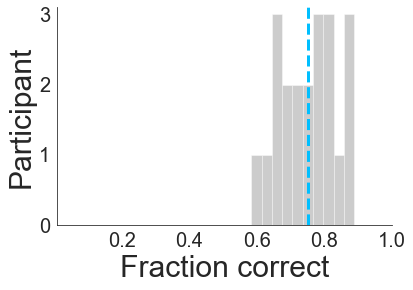

In [21]:
fig, ax = plt.subplots(figsize=(6,4))
# plt.style.use('dark_background')
ax = sns.distplot(pct_corr['correct_new'].values, bins=10, kde=False, color='grey')
plt.xlim(0,1)
plt.ylim(0.001,3.1)
plt.xlabel('Fraction correct', fontsize=30)
plt.ylabel('Participant', fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.axvline(x=acc, color='deepskyblue', linestyle='--', linewidth=3)
# ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'));
ax.set_yticks([0,1,2,3])
ax.set_xlim([0.01,1])
sns.set_style('white')
sns.despine();

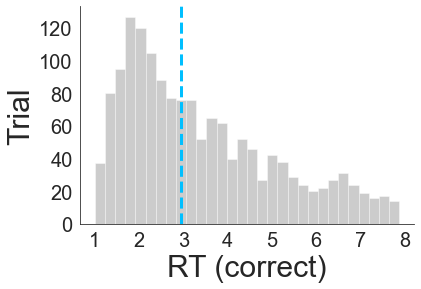

In [22]:
fig, ax = plt.subplots(figsize=(6,4))
# plt.style.use('dark_background')
# sns.distplot(np.unique(rt_correct['rt'].values), bins=50, kde=False, color='grey')
# sns.distplot(rt_trials, bins=15, kde=False, color='grey')
sns.distplot(rt_trials, bins=np.arange(1, 8, 0.22944251393843926), kde=False, color='grey')
plt.xlabel('RT (correct)', fontsize=30)
plt.ylabel('Trial', fontsize=30)
# plt.axvline(x=rt_dist[0], color='w', linestyle='--', linewidth=3)
plt.axvline(x=rt_dist[1], color='deepskyblue', linestyle='--', linewidth=3)
# plt.axvline(x=rt_dist[2], color='w', linestyle='--', linewidth=3)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
sns.set_style('white')
sns.despine();

### Percent correct by rooms: are certain scenes easier than others? 

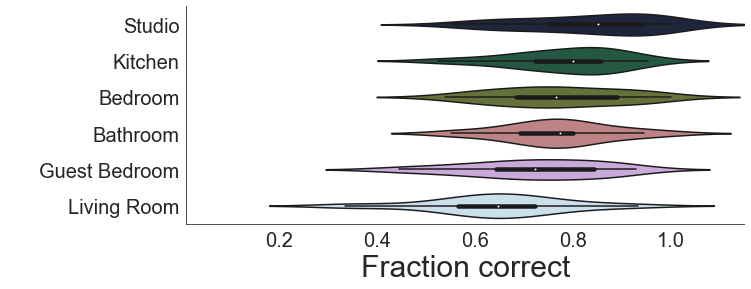

In [23]:
## Pivot to one row per trial & average by object within participant.
df = gaze.groupby(['participant','trial','room'])['correct'].value_counts().reset_index(level=(0,1,2))
df['correct_new'] = df.index.values
df = df.groupby(['participant', 'room'], as_index=False)['correct_new'].mean()

result = df.groupby(['room'], as_index=False)['correct_new'].mean().sort_values(['correct_new'], ascending=False).reset_index(drop=True)

fig, ax = plt.subplots(figsize=(10,4))
sns.violinplot(x='correct_new', y='room', data=df, palette='cubehelix', order=result['room'])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Fraction correct', fontsize=30)
plt.ylabel(' ', fontsize=30);
plt.xlim((0.01,1.15))
sns.despine()
sns.set_style('white')

In [24]:
df.to_csv('correct_by_room.csv', index=False)

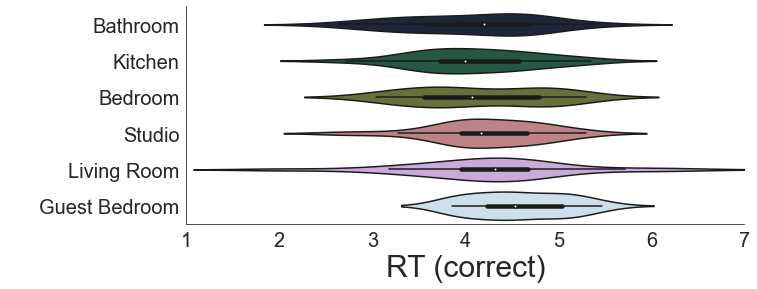

In [25]:
## Pivot to one row per trial & average by object within participant.
gaze_correct = gaze.loc[gaze['rt'] < 7.9999].reset_index(drop=True)
df = gaze_correct.groupby(['participant','room'])['rt'].mean().reset_index()

result = df.groupby(['room'], as_index=False)['rt'].mean().sort_values(['rt']).reset_index(drop=True)

fig, ax = plt.subplots(figsize=(10,4))
sns.violinplot(x='rt', y='room', data=df, palette='cubehelix', order=result['room'])
plt.xlim([1, 7])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('RT (correct)', fontsize=30)
plt.ylabel(' ', fontsize=30);
sns.despine()
sns.set_style('white')

In [26]:
df.to_csv('rt_by_room.csv', index=False)

In [27]:
gaze_correct_not_target = gaze_correct[(gaze_correct['target']) != (gaze_correct['object'])]
gaze_correct_not_target = gaze_correct_not_target[gaze_correct_not_target['valid'] == 1].reset_index()

n_fixated_objects = [] 
for p in all_participants:
    
    if False:
        verbose = True
    else: 
        verbose = False
    
    if verbose: 
        print(p)
    
    gaze_participant = gaze_correct_not_target[gaze_correct_not_target['participant'] == p]
    these_scenes = gaze_participant['scene'].unique()
    
    for s in these_scenes: 
          
        gaze_scene = gaze_participant[gaze_participant['scene'] == s]
        
        if len(gaze_scene):
            
            if verbose:
                print(s)
                
            nfo = np.unique(gaze_scene['object']).shape[0]

            if verbose:
                print(nfo)
                
            n_fixated_objects.append(nfo*np.ones(len(gaze_scene), ))
                    
x = np.concatenate(n_fixated_objects)
gaze_correct_not_target['n_fixated_objects'] = x

mean_n_fix = gaze_correct_not_target.groupby(['participant'])['n_fixated_objects'].mean().reset_index()['n_fixated_objects'].mean()
print('Average fixated objects before target: ' + str(mean_n_fix))

Average fixated objects before target: 12.608277012840114


### Percent correct by target: are certain targets easier than others? 

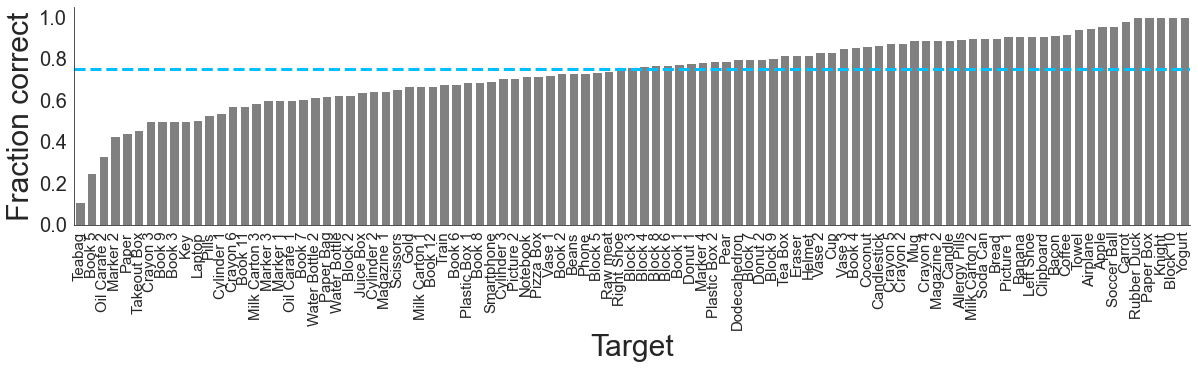

In [28]:
## Pivot to one row per trial & average by object within participant.
df = gaze.groupby(['participant','trial','target'])['correct'].value_counts().reset_index(level=(0,1,2))
df['correct_new'] = df.index.values
df = df.groupby(['participant', 'target'], as_index=False)['correct_new'].mean()

# Average across participants and sort.
result = df.groupby(['target'], as_index=False)['correct_new'].mean().sort_values(['correct_new']).reset_index(drop=True)


# Plot w/o between-subjects error since we have very few trials for each target.
fig, ax = plt.subplots(figsize=(20,4))
# sns.barplot(x='target', y='correct_new', data=df, ci=68, color='grey', order=result['target'])
sns.barplot(x='target', y='correct_new', data=result, ci=68, color='grey', order=result['target'])
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=20)
plt.xlabel('Target', fontsize=30)
plt.ylabel('Fraction correct', fontsize=30)
plt.axhline(y=df['correct_new'].mean(), color='deepskyblue', linestyle='--', linewidth=3);
sns.set_style('white')
sns.despine()

In [29]:
result.to_csv('correct_by_target.csv', index=False)

### RT on correct trials by target: are certain targets easier than others? 

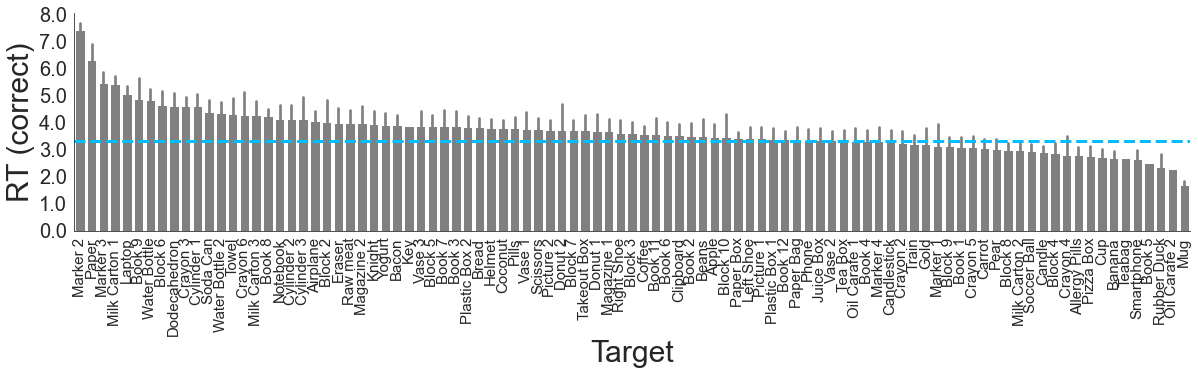

In [38]:
## Pivot to one row per trial.
gaze_correct = gaze.loc[gaze['rt'] < 7.9999].reset_index(drop=True)
df = gaze_correct.groupby(['participant','target'])['rt'].mean().reset_index()

# Average across participants and sort.
result = df.groupby(['target'], as_index=False)['rt'].mean().sort_values(['rt'], ascending=False).reset_index(drop=True)

fig, ax = plt.subplots(figsize=(20,4))
sns.barplot(x='target', y='rt', data=df, ci=68, color='grey', errcolor='grey', order=result['target'])
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=20)
plt.xlabel('Target', fontsize=30)
plt.ylabel('RT (correct)', fontsize=30)
plt.axhline(y=df['rt'].median(), color='deepskyblue', linestyle='--', linewidth=3)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'));
sns.set_style('white')
sns.despine()

In [41]:
result.to_csv('rt_by_target.csv', index=False)

### Plot one scanpath. 

Kitchen Location 1 Trial 2
P3_09272018


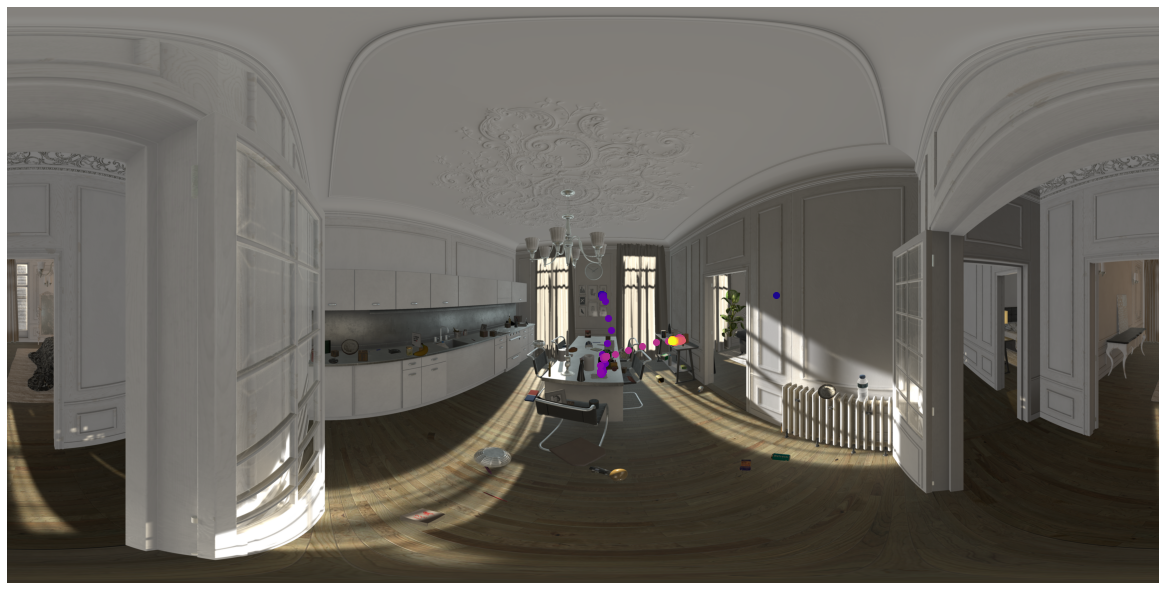

In [9]:
## Subset data for one episode. 
# participant = all_participants[0]
# scene = all_scenes[0]
scene = 'Kitchen Location 1 Trial 2'
print(scene)
gaze_scene = gaze[gaze['scene'] == scene]

## Participants this scene. 
participants_scene = np.unique(gaze_scene['participant'].values)
participant = participants_scene[6]
print(participant)

## Gaze this episode. 
gaze_episode = gaze_scene[gaze_scene['participant'] == participant]
gaze_this_trial = gaze_episode[['gaze_x_pos_pixel_360', 'gaze_y_pos_pixel_360']].values

if load_fixations: durations_this_trial = gaze_episode['duration'].values

## Load equirect for this scene.
im = imageio.imread(equirect_direc + scene + '.png')

## Grab enough colors to plot this trial's gaze. 
n_samples, dummy = gaze_this_trial.shape
cm_subsection = np.linspace(0.0, 1.0, n_samples)
colors = [cm.plasma(x) for x in cm_subsection]

# Make plot.
fig = plt.figure()
fig.set_size_inches(16,8)
ax = plt.Axes(fig, [0., 0., 1., 1.])
fig.add_axes(ax)
ax.imshow(im)
for i, color in enumerate(colors):
    # Plot point. 
    if load_fixations:
        ax.plot(gaze_this_trial[i,0],gaze_this_trial[i,1],'o',markersize=durations_this_trial[i], color=color, alpha=0.5);
    else:
        ax.plot(gaze_this_trial[i,0],gaze_this_trial[i,1],'.',markersize=12,color=color);
if load_fixations: 
    ax.plot(gaze_this_trial[:,0], gaze_this_trial[:,1],'-', color='white')
    ax.plot(gaze_this_trial[i,0],gaze_this_trial[i,1],'o',markersize=durations_this_trial[i], color=color, alpha=0.5);  

ax.set_axis_off()

### Plot representative scanpaths for one scene. 

Living Room Location 5 Trial 10
P12_10052018
P15_10082018
P16_10082018
P18_10092018
P22_10102018
P2_09262018
P6_10022018
P9_10032018


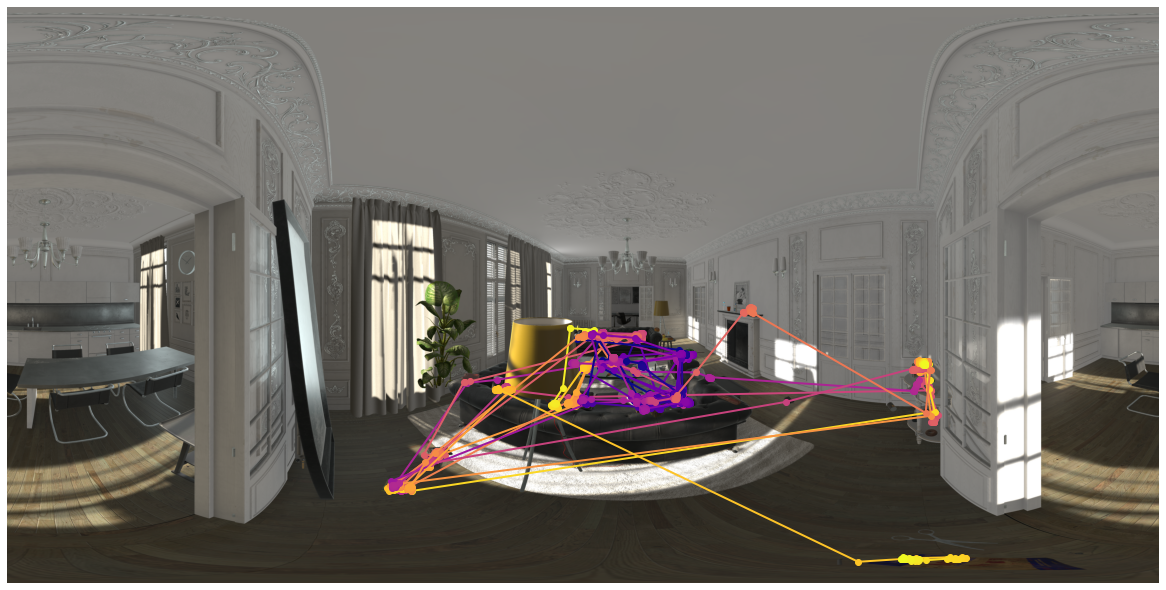

In [10]:
## Subset data for one episode. 
# 'Living Room Location 1 Trial 3' chosen to be consistent with scene in task figure.
# 'Living Room Location 1 Trial 6' compare to above
# 'Kitchen Location 1 Trial 9' for kitchen
# 'Guest Bedroom Location 3 Trial 8'
# scene = 'Kitchen Location 1 Trial 2'
scene = 'Living Room Location 5 Trial 10'

## Get gaze data for this scene. 
# gaze_scene = gaze[gaze['scene'] == scene]
gaze_scene = gaze[(gaze['valid'] == 1) & (gaze['scene'] == scene)]

## Grab participants who complete this scene without assistance. 
participants_scene = np.unique(gaze_scene['participant'].values)

## Load equirect for this scene.
im = imageio.imread(equirect_direc + scene + '.png')

print(scene)

## Prep plot.
fig = plt.figure()
fig.set_size_inches(16,8)
ax = plt.Axes(fig, [0., 0., 1., 1.])
fig.add_axes(ax)
ax.imshow(im)
    
## Loop through participants.
# for p in [participants_scene[0]]:
for p in participants_scene:
    
    print(p)

    ## Get gaze.
    gaze_episode = gaze_scene[gaze_scene['participant'] == p]
    gaze_this_trial = gaze_episode[['gaze_x_pos_pixel_360', 'gaze_y_pos_pixel_360']].values
    gaze_this_trial = gaze_this_trial[~np.isnan(gaze_this_trial).any(axis=1)]
    # First sample is eyetracker error -- check with Bas. 
    gaze_this_trial = np.delete(gaze_this_trial, (0), axis=0)

    ## Grab enough colors to plot this trial's gaze. 
    n_samples, dummy = gaze_this_trial.shape
    cm_subsection = np.linspace(0.0, 1.0, n_samples)
    colors = [cm.plasma(x) for x in cm_subsection]
    
    for i, color in enumerate(colors):
        ax.plot(gaze_this_trial[i:(i+2),0], gaze_this_trial[i:(i+2),1],'-', color=color, linewidth=2)
        ax.plot(gaze_this_trial[i,0],gaze_this_trial[i,1],'.',markersize=12,color=color);

ax.set_axis_off()

In [11]:
gaze_scene

,participant,timepoint,timestamp,frame,trial,condition,scene,room,location,trial_vp,...,target_loc_r_polar,target_loc_theta_polar,target_x_loc_pixel_360,target_y_loc_pixel_360,target_shape_1,target_shape_2,target_shape_3,target_color_1,target_color_2,target_color_3
49,P2_09262018,49,177.7151,4738,9,No,Living Room Location 5 Trial 10,Living room,NaN,NaN,...,1.8585,-0.3997,6519.0,2569.0,41.0679,-1.143,-0.6312,-76655.3982,-30849.8418,2147.5676
50,P2_09262018,50,177.7274,4739,9,No,Living Room Location 5 Trial 10,Living room,NaN,NaN,...,1.8585,-0.3997,6519.0,2569.0,41.0679,-1.143,-0.6312,-76655.3982,-30849.8418,2147.5676
116,P2_09262018,116,178.2875,4755,9,No,Living Room Location 5 Trial 10,Living room,NaN,NaN,...,1.8585,-0.3997,6519.0,2569.0,41.0679,-1.143,-0.6312,-76655.3982,-30849.8418,2147.5676
120,P2_09262018,120,178.3309,4757,9,No,Living Room Location 5 Trial 10,Living room,NaN,NaN,...,1.8585,-0.3997,6519.0,2569.0,41.0679,-1.143,-0.6312,-76655.3982,-30849.8418,2147.5676
121,P2_09262018,121,178.3312,4757,9,No,Living Room Location 5 Trial 10,Living room,NaN,NaN,...,1.8585,-0.3997,6519.0,2569.0,41.0679,-1.143,-0.6312,-76655.3982,-30849.8418,2147.5676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
929796,P22_10102018,883,933.6012,26522,72,No,Living Room Location 5 Trial 10,Living room,NaN,NaN,...,1.8585,-0.3997,6519.0,2569.0,41.0679,-1.143,-0.6312,-76655.3982,-30849.8418,2147.5676
929797,P22_10102018,884,933.6015,26522,72,No,Living Room Location 5 Trial 10,Living room,NaN,NaN,...,1.8585,-0.3997,6519.0,2569.0,41.0679,-1.143,-0.6312,-76655.3982,-30849.8418,2147.5676
929798,P22_10102018,885,933.6233,26523,72,No,Living Room Location 5 Trial 10,Living room,NaN,NaN,...,1.8585,-0.3997,6519.0,2569.0,41.0679,-1.143,-0.6312,-76655.3982,-30849.8418,2147.5676
929799,P22_10102018,886,933.6237,26523,72,No,Living Room Location 5 Trial 10,Living room,NaN,NaN,...,1.8585,-0.3997,6519.0,2569.0,41.0679,-1.143,-0.6312,-76655.3982,-30849.8418,2147.5676


In [12]:
gaze_scene[['participant', 'object', 'obj_shape_1', 'obj_shape_2', 'obj_shape_3', 'obj_color_1', 'obj_color_2', 'obj_color_3']].to_csv('sample_data.csv', index=False)

### Object level analysis for model validation.

<ipython-input-25-14cc5f949154>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0, 0.05, 0.1, 0.15, 0.2, 0.25])


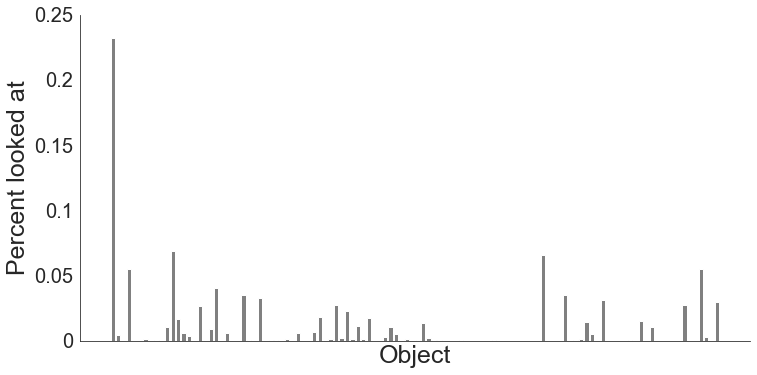

In [25]:
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

## Select scene.
scene = 'Living Room Location 5 Trial 10'
all_objects = locations[locations['scene'] == scene]['object'].values
n_objects = all_objects.shape[0]

## Count the number of valid samples for the object. Note, we do this grouping by object index 
# within scene rather than label, so that we can distinguish object clones and compare with the models.
df = gaze.loc[(gaze['scene'] == scene) & (gaze['valid'] == 1)].reset_index(drop=True)
df_avg = df.groupby('nearest_obj_idx_within_scene', as_index=False)['valid'].count()

## Append objects that were not examined. 
not_examined = np.setdiff1d(np.arange(n_objects), df_avg['nearest_obj_idx_within_scene'])
df_aux = pd.DataFrame({"nearest_obj_idx_within_scene": not_examined, "valid": 0}) 
df_avg = df_avg.append(df_aux)

## Sort by order of objects in scene.
df_avg = df_avg.sort_values('nearest_obj_idx_within_scene')

fig, ax = plt.subplots(figsize=(12,6));
# plt.style.use('dark_background')
plt.bar(x = df_avg['nearest_obj_idx_within_scene'].values, height=df_avg['valid']/np.sum(df_avg['valid'].values),color='grey')
# plt.xticks(rotation=90, fontsize=15)
# ax.set_xticks(np.arange(113))
ax.set_xticks([])
ax.set_xticklabels([])
ax.set_yticklabels([0, 0.05, 0.1, 0.15, 0.2, 0.25])
# change_width(ax, 1)
plt.yticks(fontsize=20)
plt.xlabel('Object', fontsize=25)
plt.ylabel('Percent looked at', fontsize=25)
sns.despine()
ax.set_ylim(0,0.25);
sns.set_style('white')

In [14]:
## Loop through all scenes and extract object rank. 
ranked_all = []
for scene in all_scenes: 
    
    print(scene)
    
    all_objects = locations[locations['scene'] == scene]['object'].values
    n_objects = all_objects.shape[0]
    
    df = gaze.loc[(gaze['scene'] == scene) & (gaze['valid'] == 1)].reset_index(drop=True)
    df_avg = df.groupby('nearest_obj_idx_within_scene', as_index=False)['valid'].count()

    ## Append objects that were not examined. 
    not_examined = np.setdiff1d(np.arange(n_objects), df_avg['nearest_obj_idx_within_scene'])
    df_aux = pd.DataFrame({"nearest_obj_idx_within_scene": not_examined, "valid": 0}) 
    df_avg = df_avg.append(df_aux)

    ## Sort by order of objects in scene.
    df_avg = df_avg.sort_values('nearest_obj_idx_within_scene')

    ## Make dataframe. 
    ranked_df = pd.DataFrame({'scene': scene,
                              'n_scene': np.unique(df['participant'].values).shape[0],
                              'objects': all_objects,
                              'id': df_avg['nearest_obj_idx_within_scene'].values,
                              'value': df_avg['valid'].values,
                              'rank': stats.rankdata(1-df_avg['valid'].values, method='min')})

    ranked_df['pct_looked'] = ranked_df['value'].values / np.sum(ranked_df['value'].values)
    
    ## Collect ranking. 
    ranked_all.append(ranked_df)
    
ranked_objects = pd.concat(ranked_all).reset_index(drop=True)
ranked_objects.to_csv('data/ranked_objects.csv', index=False)

Living Room Location 5 Trial 10
Bedroom Location 1 Trial 8
Bedroom Location 4 Trial 2
Studio Location 2 Trial 1
Guest Bedroom Location 3 Trial 7
Kitchen Location 3 Trial 10
Guest Bedroom Location 1 Trial 9
Guest Bedroom Location 3 Trial 8
Studio Location 3 Trial 8
Bedroom Location 4 Trial 9
Guest Bedroom Location 4 Trial 2
Living Room Location 1 Trial 8
Guest Bedroom Location 3 Trial 9
Living Room Location 5 Trial 5
Living Room Location 2 Trial 9
Bathroom Location 3 Trial 4
Guest Bedroom Location 3 Trial 2
Kitchen Location 3 Trial 9
Kitchen Location 1 Trial 3
Living Room Location 2 Trial 3
Studio Location 1 Trial 7
Kitchen Location 1 Trial 7
Bedroom Location 5 Trial 6
Kitchen Location 3 Trial 5
Guest Bedroom Location 4 Trial 6
Kitchen Location 4 Trial 10
Living Room Location 5 Trial 6
Studio Location 4 Trial 10
Studio Location 2 Trial 3
Bathroom Location 1 Trial 7
Studio Location 2 Trial 2
Studio Location 5 Trial 8
Living Room Location 2 Trial 8
Bathroom Location 3 Trial 8
Guest Bedroo

Kitchen Location 3 Trial 2
Guest Bedroom Location 4 Trial 8
Bathroom Location 5 Trial 4
Bathroom Location 4 Trial 10
Bathroom Location 2 Trial 4
Studio Location 3 Trial 6
Kitchen Location 1 Trial 5
Studio Location 5 Trial 10
Bathroom Location 4 Trial 4
Bathroom Location 1 Trial 10
Studio Location 5 Trial 1


FileNotFoundError: [Errno 2] No such file or directory: 'data/ranked_objects.csv'

### What percent of samples fall on valid objects?

In [ ]:
df = gaze.groupby('participant', as_index=False)['valid'].mean()

fig, ax = plt.subplots(figsize=(20,8));
sns.distplot(df['valid'].values, bins=np.linspace(0,1), color='white', kde=False)
plt.axvline(x=np.mean(df['valid'].values), color='deepskyblue', linestyle='--', linewidth=3)
plt.xlabel('Percent gaze samples \n on objects', fontsize=40)
plt.ylabel('# participants', fontsize=40)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
ax.set_yticks(np.arange(4))
ax.set_yticklabels(np.arange(4));

### Plot similarity between fixated object and target over time.
The collapsed version of this can be found in the similarity notebooks. 

#### Record similarity to target along shape and color. 

In [ ]:
## Stick to valid trials.
if load_fixations == 0: gaze = gaze[gaze['valid'] == 1]

## Index gaze object label into similarity matrix.
# This gives the similarity of the object being looked at to all possible targets. 
df_shape = shape_similarity_df[gaze['object']].T 
df_color = color_similarity_df[gaze['object']].T 
df_shape.columns = unique_objects
df_color.columns = unique_objects

## Reset indices. 
gaze = gaze.reset_index(drop=True)

n_samples = len(df_shape)
shape_sim_to_target = np.zeros(n_samples)
color_sim_to_target = np.zeros(n_samples)

# Loop thru all object labels and identify times when this object was the target.
for t in list(unique_objects):
    # Find sample indices where this object was the target.
    idx, = np.where(np.isin(gaze['target'], t))
    # Record similarity to target.
    shape_sim_to_target[idx] = df_shape.iloc[idx][t]
    color_sim_to_target[idx] = df_color.iloc[idx][t]
        
gaze['shape_similarity'] = shape_sim_to_target
gaze['color_similarity'] = color_sim_to_target

#### Compute location similarity.

In [ ]:
if load_fixations: obj_location = gaze[['obj_x_loc_pixel_360', 'obj_y_loc_pixel_360']].values
else: obj_location = gaze[['nearest_obj_x_loc_pixel_360', 'nearest_obj_y_loc_pixel_360']].values
    
target_location = gaze[['target_x_loc_pixel_360', 'target_y_loc_pixel_360']].values

x = np.linalg.norm(obj_location-target_location, axis=1)
x_transformed = stats.zscore(x) - np.min(stats.zscore(x))
gaze['location_similarity'] = x_transformed

#### Remove trials during which people were looking at the target.

In [ ]:
gaze_before_found = gaze[gaze['object'] != gaze['target']]

#### Reindex by time looking at objects in trial.

In [ ]:
t_start = perf_counter()

## Get array indicators. 
trial_col = gaze_before_found['trial'].values
participant_col = gaze_before_found['participant'].values

## Reindex participants by integers. 
i = 1
for p in all_participants: 
    participant_col[np.where(participant_col == p)] = i
    i = i+1
    
all_trials = np.unique(trial_col)
all_participants_idx = np.unique(participant_col)

## Make auxiliary timepoint in trial column.
time_in_trial = np.ones(len(gaze_before_found))*(-999)

## Trial loop.
for t in np.arange(n_scenes):
    
    ## Participant loop.
    for p in all_participants_idx: 
        
        indices = (trial_col == t+1)  & (participant_col == p)
        time_in_trial[np.where(indices)] = np.arange(np.where(indices)[0].shape[0])

## Add column to dataframe.
gaze_before_found['time_in_trial'] = time_in_trial

t_stop = perf_counter() 
print("Elapsed time: ", str(t_stop-t_start) + ' seconds')  

#### Further restrict time-window.

In [ ]:
if load_fixations: 
    # First 4 fixations.
    gaze_before_found = gaze_before_found[gaze_before_found['time_in_trial'] < 4].reset_index(drop=True)
else:
    # First second.
    gaze_before_found = gaze_before_found[gaze_before_found['time_in_trial'] < 200].reset_index(drop=True)

#### Plot.

NameError: name 'gaze_before_found' is not defined

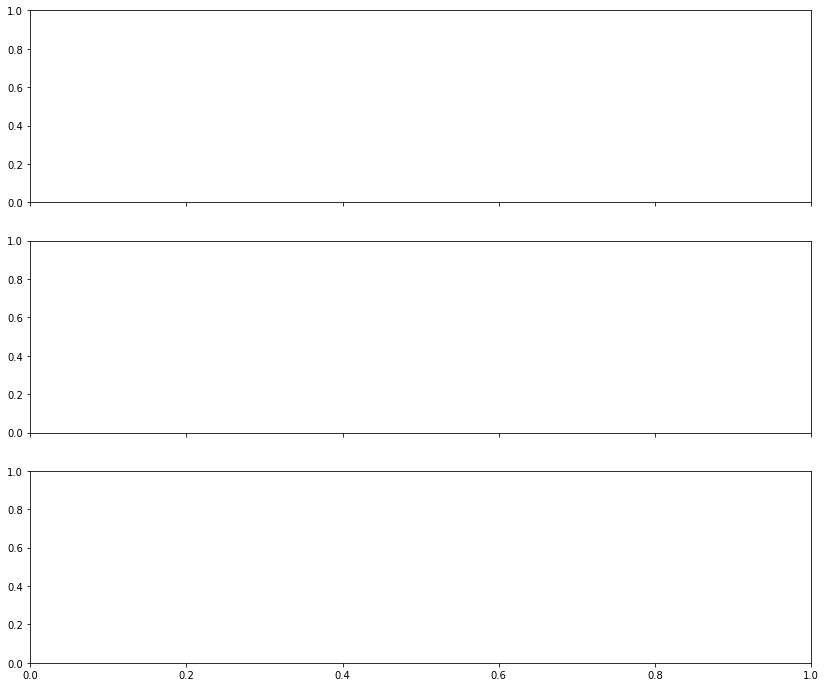

In [26]:
t_start = perf_counter()

flatui = ["#9b59b6", "#3498db", "#e74c3c", "#34495e", "#2ecc71"]

fig, ax = plt.subplots(3,1,figsize=(14,12), sharex=True)
# plt.style.use('dark_background')
sns.set_palette(sns.color_palette(flatui))
sns.lineplot(x="time_in_trial", y="shape_similarity", 
                  data=gaze_before_found, ax=ax[0], color=flatui[0], label="Shape")
sns.lineplot(x="time_in_trial", y="color_similarity", 
                  data=gaze_before_found, ax=ax[1], color=flatui[1], label="Color")
sns.lineplot(x="time_in_trial", y="location_similarity", 
                  data=gaze_before_found, ax=ax[2], color='k', label="Location")

ax[0].set_ylim([0.9, 1.2]) 
ax[0].set_ylabel('Distance (sd)', fontsize=22) 
ax[0].tick_params(labelsize=20)
ax[0].legend(loc='lower right', prop={'size': 20}, frameon=False)

ax[1].set_ylim([1.1, 1.5]) 
ax[1].set_ylabel('Distance (sd)', fontsize=22) 
ax[1].tick_params(labelsize=20)
ax[1].legend(loc='lower right', prop={'size': 20}, frameon=False)

ax[2].set_ylim([0.8, 1.4]) 
ax[2].set_ylabel('Distance (sd)', fontsize=22) 
ax[2].tick_params(labelsize=20)
ax[2].legend(loc=4, prop={'size': 20}, frameon=False)
ax[2].set_xlabel('Time in trial (valid non-targets)', fontsize = 22) 

t_stop = perf_counter() 
print("Elapsed time: ", str(t_stop-t_start) + ' seconds')  